Loading data...
Train words: 49979, Test words: 2000
Fitting Bigram HMM from scratch...
Training Q-learning agent...
Episode 1/8000 | total_reward=-25.00 | eps=0.5997 | elapsed=0.0s
Episode 200/8000 | total_reward=-29.00 | eps=0.5429 | elapsed=2.7s
Episode 400/8000 | total_reward=-12.00 | eps=0.4912 | elapsed=5.0s
Episode 600/8000 | total_reward=-37.00 | eps=0.4445 | elapsed=7.2s
Episode 800/8000 | total_reward=-25.00 | eps=0.4022 | elapsed=10.2s
Episode 1000/8000 | total_reward=-8.00 | eps=0.3639 | elapsed=13.5s
Episode 1200/8000 | total_reward=-25.00 | eps=0.3292 | elapsed=16.1s
Episode 1400/8000 | total_reward=-20.00 | eps=0.2979 | elapsed=18.6s
Episode 1600/8000 | total_reward=-29.00 | eps=0.2695 | elapsed=21.2s
Episode 1800/8000 | total_reward=-32.00 | eps=0.2439 | elapsed=24.9s
Episode 2000/8000 | total_reward=50.00 | eps=0.2207 | elapsed=27.6s
Episode 2200/8000 | total_reward=-28.00 | eps=0.1997 | elapsed=30.3s
Episode 2400/8000 | total_reward=-24.00 | eps=0.1807 | elapsed=33.0s

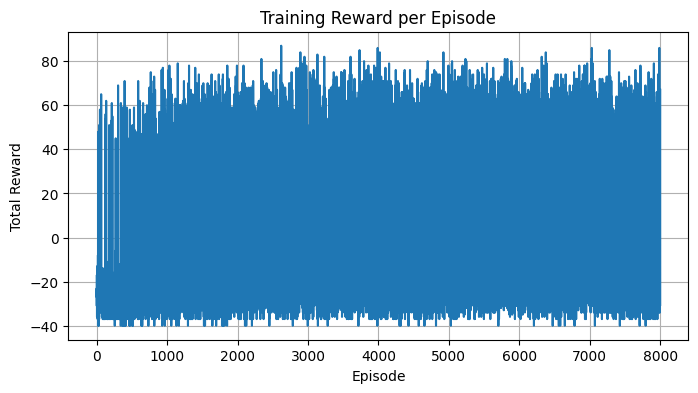

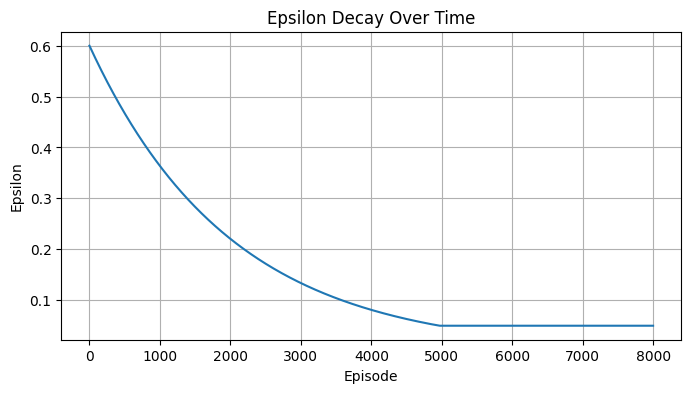

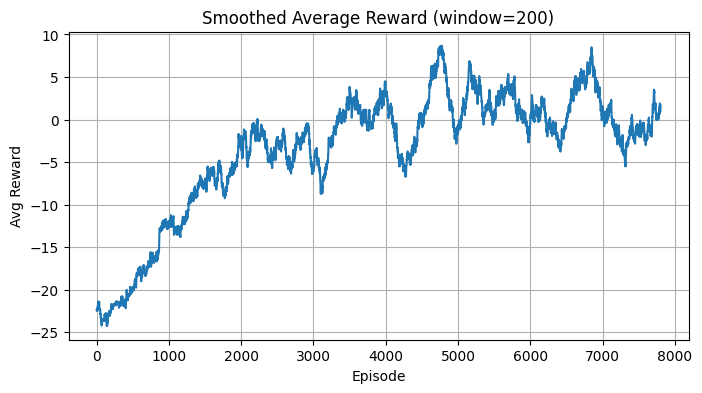

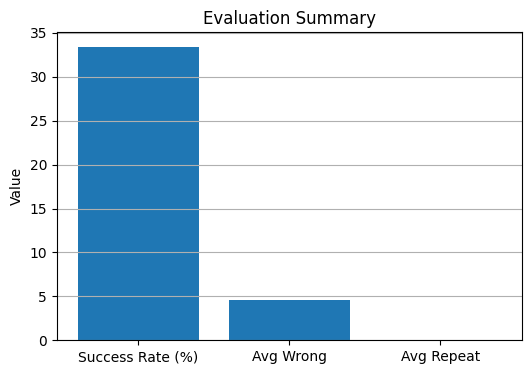

In [1]:
import os
import math
import random
import time
from collections import defaultdict, Counter
import numpy as np

# -------------------- Config --------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

CORPUS_PATH = "corpus.txt"
TEST_PATH   = "test.txt"

ALPHABET = [chr(ord("a") + i) for i in range(26)]
A2I = {c: i for i, c in enumerate(ALPHABET)}
I2A = {i: c for c, i in A2I.items()}

MAX_LIVES = 6

# Q-learning params
ALPHA = 0.3
GAMMA = 0.95
EPS_START = 0.6
EPS_END = 0.05
EPS_DECAY = 0.9995   # multiplicative per episode
TRAIN_EPISODES = 8000

# -------------------- Utilities --------------------
def load_words(path):
    assert os.path.exists(path), f"{path} missing"
    out = []
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            w = ln.strip().lower()
            if w and w.isalpha():
                out.append(w)
    return out

# -------------------- 1) HMM (bigram) built from scratch --------------------
class BigramHMM:
    def __init__(self, alpha=0.5):
        self.alpha = float(alpha)
        self.trans = None
        self.pi = None
        self.V = 26

    def fit(self, words):
        C = np.zeros((self.V, self.V), dtype=np.float64)
        starts = np.zeros(self.V, dtype=np.float64)
        for w in words:
            if len(w) == 0: continue
            w = ''.join([c for c in w if c in A2I])
            if len(w) == 0: continue
            starts[A2I[w[0]]] += 1
            for a, b in zip(w[:-1], w[1:]):
                C[A2I[a], A2I[b]] += 1
        row_sums = C.sum(axis=1, keepdims=True)
        self.trans = (C + self.alpha) / (row_sums + self.alpha * self.V + 1e-12)
        self.pi = (starts + self.alpha) / (starts.sum() + self.alpha * self.V + 1e-12)

    @staticmethod
    def _log(x):
        return np.log(x + 1e-300)

    @staticmethod
    def _logsumexp(a, axis=None):
        a_max = np.max(a, axis=axis, keepdims=True)
        s = np.sum(np.exp(a - a_max), axis=axis, keepdims=True)
        out = a_max + np.log(s + 1e-300)
        if axis is not None:
            out = np.squeeze(out, axis=axis)
        return out

    def forward_backward_letter_posterior(self, pattern, guessed_set):
        L = len(pattern)
        if L == 0:
            out = np.ones(self.V, dtype=float)
            for g in guessed_set:
                out[A2I[g]] = 0.0
            s = out.sum()
            return (out / s) if s > 0 else (np.ones(self.V) / self.V)

        E = np.zeros((L, self.V), dtype=float)
        revealed = set(ch for ch in pattern if ch != "_")
        wrong = set(ch for ch in guessed_set if ch not in revealed)
        for t, ch in enumerate(pattern):
            if ch == "_":
                for c in ALPHABET:
                    if c in wrong: continue
                    if c in revealed: continue
                    E[t, A2I[c]] = 1.0
            else:
                E[t, A2I[ch]] = 1.0
        for t in range(L):
            if E[t].sum() == 0:
                for c in ALPHABET:
                    if c not in wrong:
                        E[t, A2I[c]] = 1.0

        logA = self._log(self.trans)
        logpi = self._log(self.pi)
        logB = np.log(E + 1e-300)

        log_alpha = np.full((L, self.V), -1e300)
        log_alpha[0] = logpi + logB[0]
        for t in range(1, L):
            temp = log_alpha[t-1][:, None] + logA
            log_alpha[t] = self._logsumexp(temp, axis=0) + logB[t]

        log_beta = np.full((L, self.V), -1e300)
        log_beta[-1] = 0.0
        for t in range(L-2, -1, -1):
            temp = logA + (logB[t+1] + log_beta[t+1])[None, :]
            log_beta[t] = self._logsumexp(temp, axis=1)

        log_gamma = log_alpha + log_beta
        for t in range(L):
            log_gamma[t] -= self._logsumexp(log_gamma[t], axis=0)
        gamma = np.exp(log_gamma)

        post = np.zeros(self.V, dtype=float)
        for t,ch in enumerate(pattern):
            if ch == "_":
                post += gamma[t]
        for g in guessed_set:
            if g in A2I:
                post[A2I[g]] = 0.0
        s = post.sum()
        if s <= 0:
            post = np.array([0.0]*self.V, dtype=float)
            unseen = [A2I[c] for c in ALPHABET if c not in guessed_set]
            if not unseen:
                post[:] = 1.0/self.V
            else:
                for i in unseen: post[i] = 1.0
            s = post.sum()
        return post / s

# -------------------- 2) Hangman Environment --------------------
class HangmanEnv:
    def __init__(self, words, hmm_model):
        self.words = words
        self.hmm = hmm_model
        self.max_lives = MAX_LIVES
        self.reset()

    def reset(self):
        self.word = random.choice(self.words)
        self.pattern = ["_"] * len(self.word)
        self.guessed = set()
        self.lives = self.max_lives
        self.done = False
        return self.get_state()

    def get_state(self):
        pattern_str = "".join(self.pattern)
        hmm_probs = self.hmm.forward_backward_letter_posterior(pattern_str, self.guessed)
        return {
            "pattern": pattern_str,
            "guessed": set(self.guessed),
            "lives": self.lives,
            "hmm_probs": hmm_probs
        }

    def step(self, letter):
        if self.done:
            return self.get_state(), 0.0, True
        if letter in self.guessed:
            return self.get_state(), -2.0, False

        self.guessed.add(letter)
        if letter in self.word:
            revealed = 0
            for i,ch in enumerate(self.word):
                if ch == letter and self.pattern[i] == "_":
                    self.pattern[i] = letter
                    revealed += 1
            reward = 2.0 + 1.0*revealed
        else:
            self.lives -= 1
            reward = -5.0

        if "_" not in self.pattern:
            self.done = True
            reward += 50.0
        elif self.lives <= 0:
            self.done = True
            reward -= 10.0
        return self.get_state(), reward, self.done

# -------------------- 3) Q-Learning Agent --------------------
class QLearningAgent:
    def __init__(self, alpha=ALPHA, gamma=GAMMA, epsilon=EPS_START):
        self.q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    @staticmethod
    def _guessed_mask(guessed):
        return ''.join('1' if c in guessed else '0' for c in ALPHABET)

    @staticmethod
    def _hmm_key(hmm_probs):
        return tuple([round(float(x), 3) for x in hmm_probs])

    def state_key(self, state):
        pattern = state["pattern"]
        guessed_mask = self._guessed_mask(state["guessed"])
        lives = int(state["lives"])
        hmmk = self._hmm_key(state["hmm_probs"])
        return (pattern, guessed_mask, lives, hmmk)

    def get_q(self, state_key, action):
        return self.q.get((state_key, action), 0.0)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            avail = [c for c in ALPHABET if c not in state["guessed"]]
            return random.choice(avail) if avail else random.choice(ALPHABET)
        sk = self.state_key(state)
        hmm_prior = state["hmm_probs"]
        best_a = None
        best_v = -1e9
        for c in ALPHABET:
            if c in state["guessed"]:
                continue
            qv = self.get_q(sk, c)
            score = qv + 1.5 * float(hmm_prior[A2I[c]])
            if score > best_v:
                best_v = score
                best_a = c
        if best_a is None:
            return random.choice(ALPHABET)
        return best_a

    def update(self, state, action, reward, next_state, done):
        sk = self.state_key(state)
        nk = self.state_key(next_state)
        cur = self.get_q(sk, action)
        if done:
            target = reward
        else:
            max_next = max([self.get_q(nk, a) for a in ALPHABET])
            target = reward + self.gamma * max_next
        self.q[(sk, action)] = cur + self.alpha * (target - cur)

# -------------------- 4) Training loop (with reward logging) --------------------
def train_q_learning(hmm_model, train_words, episodes=TRAIN_EPISODES):
    env = HangmanEnv(train_words, hmm_model)
    agent = QLearningAgent()
    eps = EPS_START
    start = time.time()

    rewards_per_episode = []
    epsilons = []

    for ep in range(1, episodes+1):
        state = env.reset()
        total_r = 0.0
        done = False
        while not done:
            a = agent.choose_action(state)
            next_state, reward, done = env.step(a)
            agent.update(state, a, reward, next_state, done)
            state = next_state
            total_r += reward

        agent.epsilon = max(EPS_END, agent.epsilon * EPS_DECAY)
        rewards_per_episode.append(total_r)
        epsilons.append(agent.epsilon)

        if ep % 200 == 0 or ep == 1:
            elapsed = time.time() - start
            print(f"Episode {ep}/{episodes} | total_reward={total_r:.2f} | eps={agent.epsilon:.4f} | elapsed={elapsed:.1f}s")

    return agent, rewards_per_episode, epsilons

# -------------------- 5) Evaluation --------------------
def evaluate(agent, hmm_model, test_words, n_games=2000):
    agent_epsilon_backup = agent.epsilon
    agent.epsilon = 0.0
    success = 0
    total_wrong = 0
    total_repeat = 0
    eval_list = test_words.copy()
    if len(eval_list) >= n_games:
        eval_list = random.sample(eval_list, n_games)
    else:
        while len(eval_list) < n_games:
            eval_list.append(random.choice(test_words))
    for w in eval_list:
        env = HangmanEnv([w], hmm_model)
        state = env.reset()
        done = False
        while not done:
            a = agent.choose_action(state)
            prev_guessed = set(env.guessed)
            state, reward, done = env.step(a)
            if reward == -5.0:
                total_wrong += 1
            if reward == -2.0:
                total_repeat += 1
            if done:
                if "_" not in state["pattern"]:
                    success += 1
                break
    sr_fraction = success / n_games
    final_score = (sr_fraction * 2000.0) - (5.0 * total_wrong) - (2.0 * total_repeat)
    agent.epsilon = agent_epsilon_backup
    return {
        "games": n_games,
        "wins": success,
        "sr_fraction": sr_fraction,
        "total_wrong": total_wrong,
        "total_repeat": total_repeat,
        "final_score": final_score
    }

# -------------------- 6) Main run with visualizations --------------------
def main():
    print("Loading data...")
    train_words = load_words(CORPUS_PATH)
    test_words  = load_words(TEST_PATH)
    print(f"Train words: {len(train_words)}, Test words: {len(test_words)}")

    print("Fitting Bigram HMM from scratch...")
    hmm = BigramHMM(alpha=0.5)
    hmm.fit(train_words)

    print("Training Q-learning agent...")
    agent, rewards_per_episode, epsilons = train_q_learning(hmm, train_words, episodes=TRAIN_EPISODES)

    print("Evaluating on test set...")
    res = evaluate(agent, hmm, test_words, n_games=2000)
    print("\n=== RESULTS ===")
    print(f"Games: {res['games']}, Wins: {res['wins']}, SR_fraction: {res['sr_fraction']:.4f}")
    print(f"Wrong total: {res['total_wrong']}, Repeats: {res['total_repeat']}")
    print(f"Final Score: {res['final_score']:.1f}")
    print("===============")

    # -------- Visualization Section --------
    import matplotlib.pyplot as plt

    # Reward per Episode
    plt.figure(figsize=(8,4))
    plt.plot(rewards_per_episode)
    plt.title("Training Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()

    # Epsilon Decay
    plt.figure(figsize=(8,4))
    plt.plot(epsilons)
    plt.title("Epsilon Decay Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.grid(True)
    plt.show()

    # Smoothed Reward Curve
    window = 200
    rolling_avg = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(8,4))
    plt.plot(rolling_avg)
    plt.title(f"Smoothed Average Reward (window={window})")
    plt.xlabel("Episode")
    plt.ylabel("Avg Reward")
    plt.grid(True)
    plt.show()

    # Evaluation Summary
    plt.figure(figsize=(6,4))
    labels = ['Success Rate (%)', 'Avg Wrong', 'Avg Repeat']
    values = [res['sr_fraction']*100, res['total_wrong']/res['games'], res['total_repeat']/res['games']]
    plt.bar(labels, values)
    plt.title("Evaluation Summary")
    plt.ylabel("Value")
    plt.grid(axis='y')
    plt.show()

    return agent, hmm, res

# -------------------- Run --------------------
if __name__ == "__main__":
    main()
